# Testing different inverse parameters

In [1]:
import os
import numpy as np
from scipy.fft import rfft, rfftfreq
from mayavi import mlab
mlab.init_notebook('png')

import mne
mne.cuda.init_cuda()

Notebook initialized with png backend.
Now using CUDA device 0
Enabling CUDA with 2.97 GB available memory


### setup/config

In [2]:
subj = 'prek_1262'
timepoint = 'pre'
#root = '/mnt/scratch/prek'  # colchuck
root = '/data/prek'          # agelaius

subjects_dir = os.path.join(root, 'anat')

# if you want to save intermediate files:
evk_dir = os.path.join(root, 'results', 'evoked')
stc_dir = os.path.join(root, 'results', 'stc')
brain_dir = os.path.join(root, 'results', 'fig', 'brain')
for _dir in (brain_dir,):
    os.makedirs(_dir, exist_ok=True)

In [3]:
# config
runs = (1, 2)
trial_dur = 20        # seconds
subdivide_epochs = 5  # seconds

# filename config
subdiv = f'-{subdivide_epochs}_sec' if subdivide_epochs else ''
filename_stub = f'{subj}-{timepoint}_camp-pskt{subdiv}'

In [4]:
snr = 3.
lambda2 = 1. / snr ** 2
smoothing_steps = 10

### Load Evoked

In [5]:
fname = f'{filename_stub}-ave.fif'
evoked = mne.read_evokeds(os.path.join(evk_dir, fname))[0]

Reading /data/prek/results/evoked/prek_1262-pre_camp-pskt-5_sec-ave.fif ...
    Read a total of 4 projection items:
        planar-ECG--0.08-0.08-PCA-01 (1 x 204) active
        axial-ECG--0.08-0.08-PCA-01 (1 x 102) active
        planar-EOG--0.25-0.25-PCA-01 (1 x 204) active
        axial-EOG--0.25-0.25-PCA-01 (1 x 102) active
    Found the data of interest:
        t =       0.00 ...    4980.00 ms (0.50 * ps + 0.50 * kt)
        0 CTF compensation matrices available
        nave = 48 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


### Do FFT

In [6]:
# do FFT
spacing = 1. / evoked.info['sfreq']
freqs = rfftfreq(evoked.times.size, spacing)
spectrum = rfft(evoked.data, workers=-2)

# convert to frequency-domain evoked object
evoked_spect = mne.EvokedArray(spectrum, evoked.info, nave=evoked.nave)
evoked_spect.times = freqs
evoked_spect.info['sfreq'] = 1. / np.diff(freqs[:2])[0]

### brain plot setup

In [7]:
# we can't do this in a for-loop because we need one image per notebook cell in order for them to show up
# so we'll use a function instead
def plot_a_brain(constraint, ori):
    # load inverse
    inv_path = os.path.join(root, f'{timepoint}_camp', 'twa_hp', 'erp', subj, 'inverse', f'{subj}-80-sss-meg{constraint}-inv.fif')
    inverse = mne.minimum_norm.read_inverse_operator(inv_path, verbose=False)
    # apply inverse
    stc = mne.minimum_norm.apply_inverse(evoked_spect, inverse, lambda2, pick_ori=ori, verbose=False)
    assert stc.tstep == np.diff(freqs[:2])
    assert np.all(stc.times == freqs)
    # replace complex-valued STC data with magnitude, then plot
    stc.data = np.abs(stc.data)
    #title = f"{ori or 'None'}, {constraint[1:] or 'loose'}"
    brain = stc.plot(subject=subj.upper(), initial_time=2, subjects_dir=subjects_dir,
                     size=600, views=['lat', 'med', 'ven'])  #, title=title)
    return brain

Here is what the various options mean

#### orientation options when making the inverse operator

Quoting @larsoner:

> loose vs fixed is usually a subtle difference, so you might as well go with loose since it's supposed to be better. loose/fixed vs free is the big difference, and you should stick with loose/fixed if you trust your subject MRI data

#### Orientation options when applying the inverse operator (`pick_ori`)

* `None`: Pooling is performed by taking the norm of loose/free orientations. In case of a fixed source space no norm is computed leading to signed source activity.
* `"normal"`: Only the normal to the cortical surface is kept. This is only implemented when working with loose orientations.
* `"vector"`: No pooling of the orientations is done, and the vector result will be returned in the form of a mne.VectorSourceEstimate object.

#### depth weighting

Quoting from [MNE algorithms documentation](https://mne.tools/dev/overview/implementation.html#noise-normalization):

> [Noise normalization, e.g., via dSPM] reduces the location bias of the estimates. In particular, the tendency of the MNE to prefer superficial currents is eliminated.

## Magnitude+direction (vector source estimate)
#### fixed orientation constraint

Using mayavi 3d backend.

Using control points [ 36.66626023  46.97363228 202.22931172]



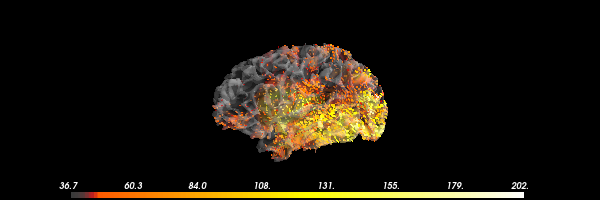


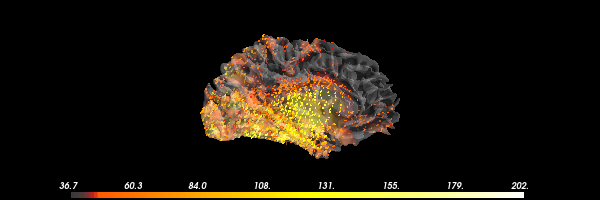


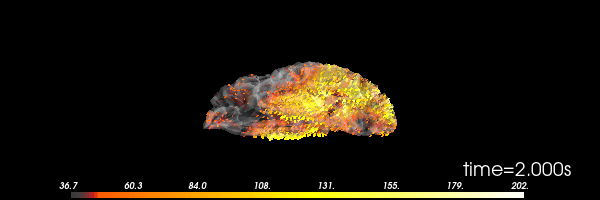

In [8]:
plot_a_brain(constraint='-fixed', ori='vector')

#### loose orientation constraint

Using control points [ 36.69157039  46.67651567 195.92106414]



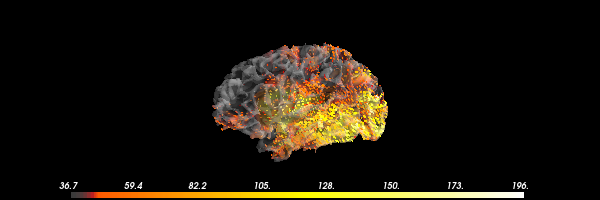


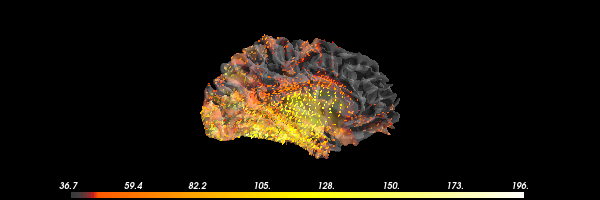


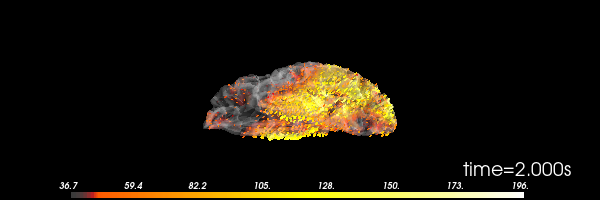

In [9]:
plot_a_brain(constraint='', ori='vector')

#### free orientation constraint

Using control points [ 37.05981713  47.35804838 180.72697943]



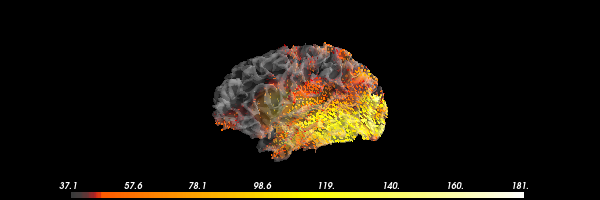


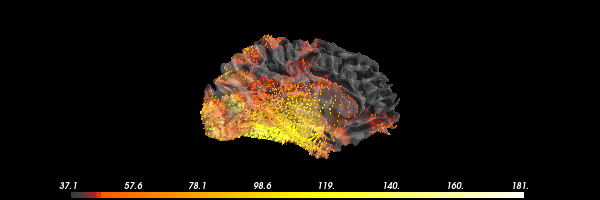


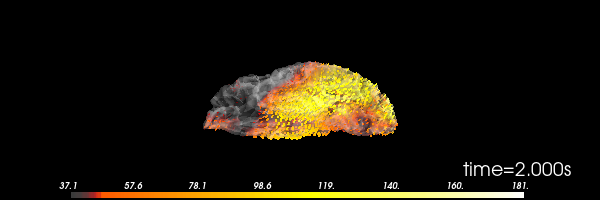

In [10]:
plot_a_brain(constraint='-free', ori='vector')

## Magnitude only
#### fixed orientation constraint

This one will have signed source activity

Using control points [ 65.13586417  83.96885715 291.59276732]



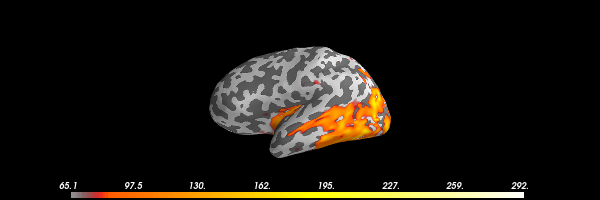


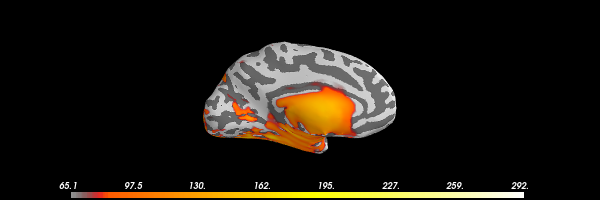


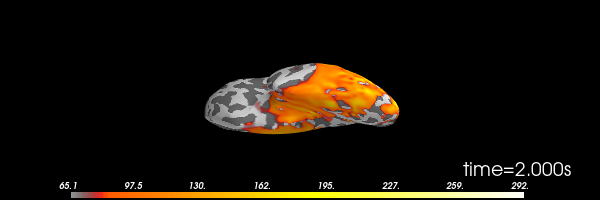

In [11]:
plot_a_brain(constraint='-fixed', ori=None)

#### loose orientation constraint

Using control points [ 65.16039635  83.77683871 283.39497555]



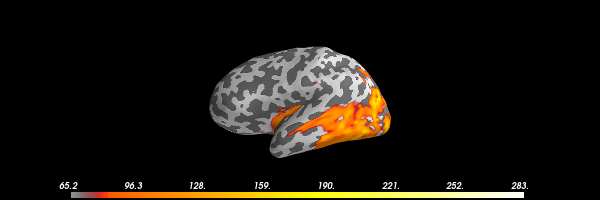


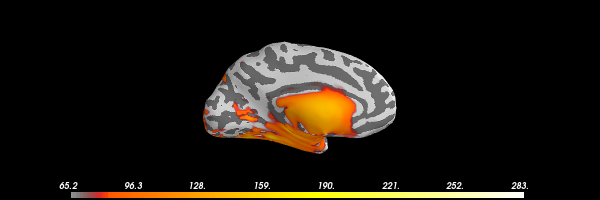


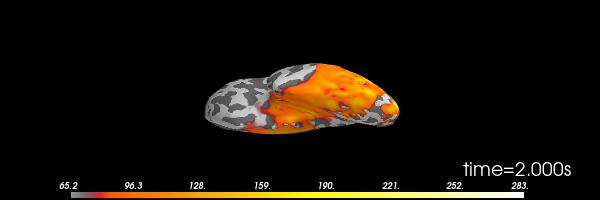

In [12]:
plot_a_brain(constraint='', ori=None)

#### free orientation constraint

Using control points [ 66.34146619  84.62972525 260.76011556]



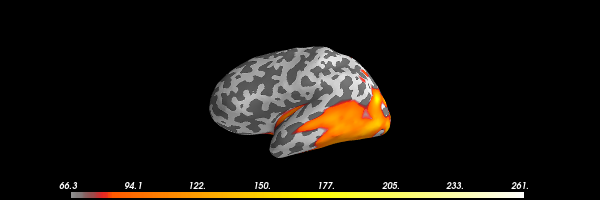


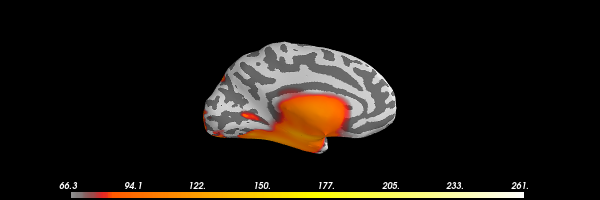


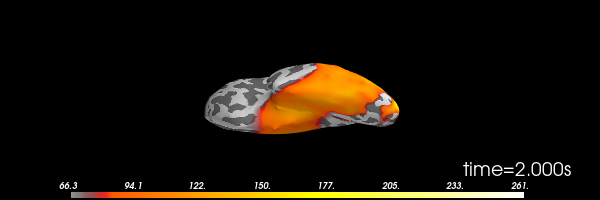

In [13]:
plot_a_brain(constraint='-free', ori=None)

## Only cortex-normal component of magnitude
#### fixed orientation constraint

In [14]:
# plot_a_brain(constraint='-fixed', ori='normal')
# (not implemented)

#### loose orientation constraint

Using control points [ 61.07807656  78.39646051 276.11203249]



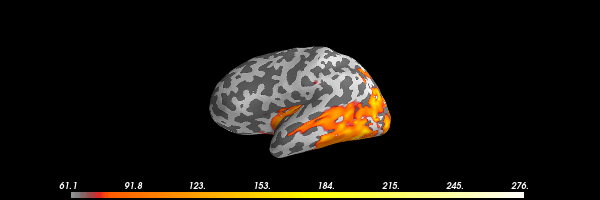


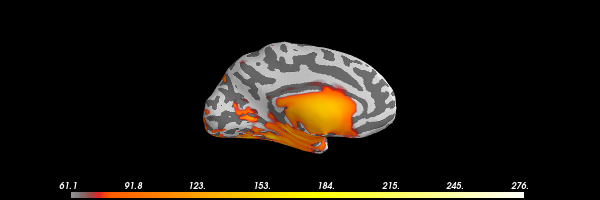


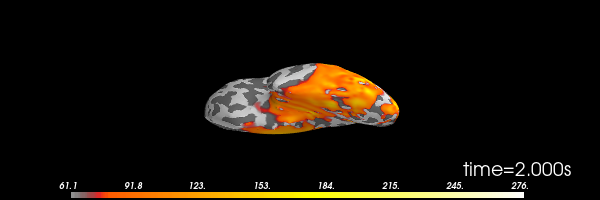

In [15]:
plot_a_brain(constraint='', ori='normal')

#### free orientation constraint

Using control points [ 37.56920919  47.80928546 178.86818369]



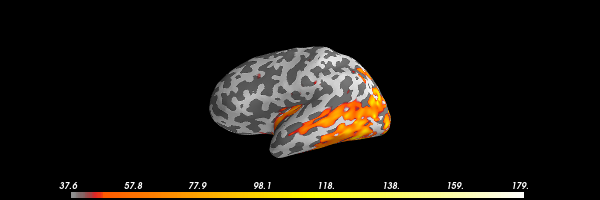


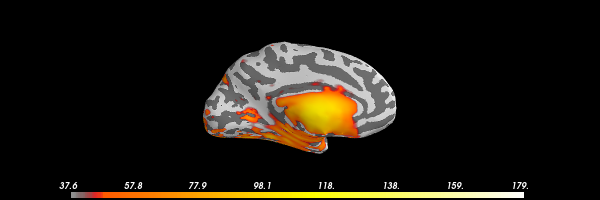


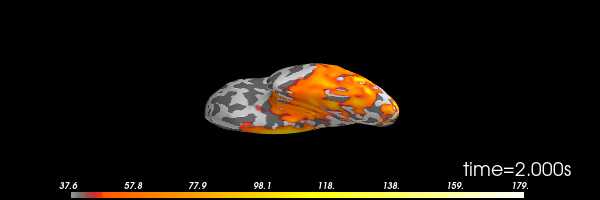

In [16]:
plot_a_brain(constraint='-free', ori='normal')